In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

# Load dataset
df = pd.read_csv('portugal_listinigs2.csv', low_memory=False)

# Target and Features
y = df['Price']
X = df.drop(columns=['Price'])

X = X[~y.isna()]
y = y[~y.isna()]

# Cap outliers in target
y = y.clip(lower=y.quantile(0.01), upper=y.quantile(0.99))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Column types
numeric_columns = ['Parking', 'TotalArea', 'LivingArea', 'TotalRooms', 'NumberOfBathrooms']
categorical_columns = ['District', 'City', 'Type', 'EnergyCertificate', 'Elevator', 'ConstructionYear']

# Fix dtype
for col in categorical_columns:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Custom functions for preprocessing
def random_impute(X, columns=['ConstructionYear']):
    X = pd.DataFrame(X, columns=columns) if isinstance(X, np.ndarray) else X
    for col in columns:
        missing = X[col].isna()
        X.loc[missing, col] = np.random.randint(1960, 2020, size=missing.sum())
    return X

def cap_outliers_iqr(X, columns):
    X = pd.DataFrame(X, columns=columns) if isinstance(X, np.ndarray) else X
    for col in columns:
        Q1, Q3 = X[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        X[col] = X[col].clip(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    return X

class TopCategoriesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=4):
        self.top_n = top_n
        self.top_categories_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            self.top_categories_[col] = list(X[col].value_counts().nlargest(self.top_n).index)
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        X_new = pd.DataFrame()
        for col in X.columns:
            top = self.top_categories_[col]
            X_temp = X[col].apply(lambda x: x if x in top else 'Other')
            dummies = pd.get_dummies(X_temp, prefix=col, drop_first=False)
            X_new = pd.concat([X_new, dummies], axis=1)
        return X_new

# Preprocessing pipelines
numeric_preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('outlier_cap', FunctionTransformer(cap_outliers_iqr, validate=False, kw_args={'columns': numeric_columns})),
    ('scaler', StandardScaler())
])

categorical_preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('top_encoder', TopCategoriesEncoder(top_n=4))
])

preprocessor = ColumnTransformer([
    ('num', numeric_preprocessor, numeric_columns),
    ('cat', categorical_preprocessor, categorical_columns)
])

pipeline = Pipeline([
    ('random_impute', FunctionTransformer(random_impute, validate=False, kw_args={'columns': ['ConstructionYear']})),
    ('preprocessor', preprocessor)
])

In [2]:
# Transform the data
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [3]:
# Add bias term
X_train = np.hstack([np.ones((X_train_transformed.shape[0], 1)), X_train_transformed])
X_test = np.hstack([np.ones((X_test_transformed.shape[0], 1)), X_test_transformed])


In [4]:
def evaluate_model(y_true, y_pred, X_test, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    n, k = len(y_true), X_test.shape[1] - 1
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
    print(f"\n{model_name}")
    print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | R2: {r2:.4f} | Adj R2: {adj_r2:.4f}")

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (103632, 34)
Shape of y_train: (103632, 1)
Shape of X_test: (25909, 34)
Shape of y_test: (25909, 1)


In [13]:
# Gradient Descent Methods

def mini_batch_gradient_descent(X, y, lr=0.1, n_iters=1000, batch_size=32):
    theta = np.zeros((X.shape[1], 1))
    for _ in range(n_iters):
        indices = np.random.permutation(X.shape[0])
        X_shuf, y_shuf = X[indices], y[indices]
        for start in range(0, X.shape[0], batch_size):
            end = start + batch_size
            xi, yi = X_shuf[start:end], y_shuf[start:end]
            theta -= lr * (xi.T @ (xi @ theta - yi)) / batch_size
    return theta

# Train all models
models = {
    "Mini-Batch GD": mini_batch_gradient_descent(X_train, y_train)
}

for name, theta in models.items():
    y_pred = X_test @ theta
    evaluate_model(y_test, y_pred, X_test, name)


Mini-Batch GD
MAE: 215334.58 | MSE: 131496195212.13 | RMSE: 362624.04 | R2: 0.3214 | Adj R2: 0.3205


In [7]:
# Sklearn Regressors
reg_models = {
    "Linear Regression": LinearRegression(fit_intercept=False),
    "Ridge Regression": Ridge(alpha=1.0, fit_intercept=False),
    "Lasso Regression": Lasso(alpha=0.1, fit_intercept=False),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.5, fit_intercept=False)
}

for name, model in reg_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred, X_test, name)


Linear Regression
MAE: 207324.97 | MSE: 128369980599.29 | RMSE: 358287.57 | R2: 0.3375 | Adj R2: 0.3367

Ridge Regression
MAE: 207354.78 | MSE: 128372237851.68 | RMSE: 358290.72 | R2: 0.3375 | Adj R2: 0.3367


c:\Users\PMYLS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.193e+14, tolerance: 3.189e+12
  model = cd_fast.enet_coordinate_descent(



Lasso Regression
MAE: 207360.05 | MSE: 128373442511.89 | RMSE: 358292.40 | R2: 0.3375 | Adj R2: 0.3367

ElasticNet Regression
MAE: 201494.09 | MSE: 130559300275.73 | RMSE: 361329.91 | R2: 0.3262 | Adj R2: 0.3254


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,   
    max_depth=10,        
    min_samples_leaf=3,   
    random_state=42,
    n_jobs=-1             
)

rf.fit(X_train, y_train)

# Evaluate on Training Set
y_train_pred = rf.predict(X_train)
evaluate_model(y_train, y_train_pred, X_train, "RandomForest (Train)")

# Evaluate on Testing Set
y_test_pred = rf.predict(X_test)
evaluate_model(y_test, y_test_pred, X_test, "RandomForest (Test)")


c:\Users\PMYLS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



RandomForest (Train)
MAE: 152274.81 | MSE: 83060240406.52 | RMSE: 288201.74 | R2: 0.5696 | Adj R2: 0.5695

RandomForest (Test)
MAE: 159554.74 | MSE: 94833961568.91 | RMSE: 307951.23 | R2: 0.5106 | Adj R2: 0.5100


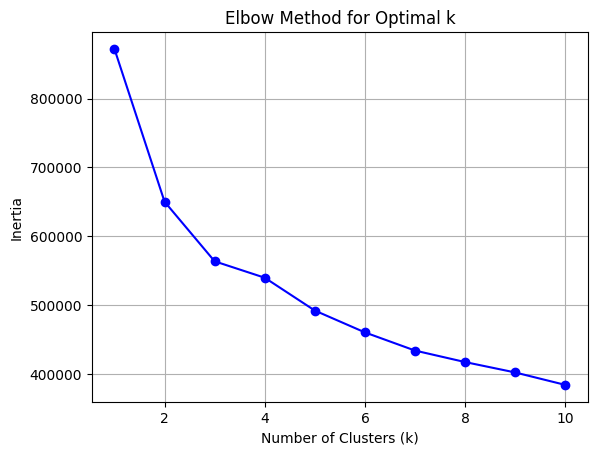

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


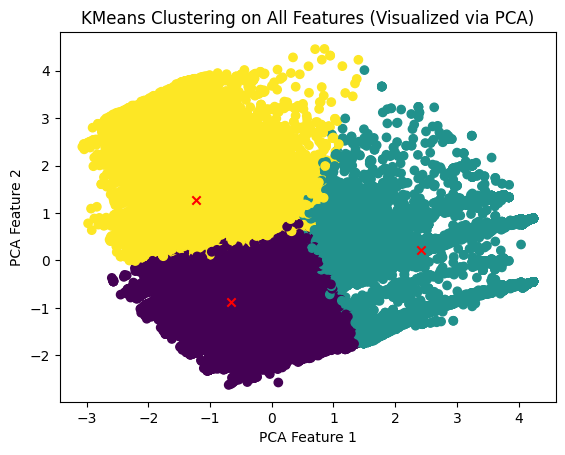

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Use all features for clustering
X_cluster = X_train

# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)
centers_pca = pca.transform(kmeans.cluster_centers_)

# Plot the clusters in 2D
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], color='red', marker='x')
plt.title("KMeans Clustering on All Features (Visualized via PCA)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()


In [11]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Silhouette Score
sil_score = silhouette_score(X_cluster, cluster_labels)
print("Silhouette Score:", sil_score)

# Davies-Bouldin Score
db_score = davies_bouldin_score(X_cluster, cluster_labels)
print("Davies-Bouldin Score:", db_score)


Silhouette Score: 0.21438955150545835
Davies-Bouldin Score: 1.8749612497316719


C:\Users\PMYLS\AppData\Local\Temp\ipykernel_21144\2931635362.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Target", data=df_cluster, palette="viridis")


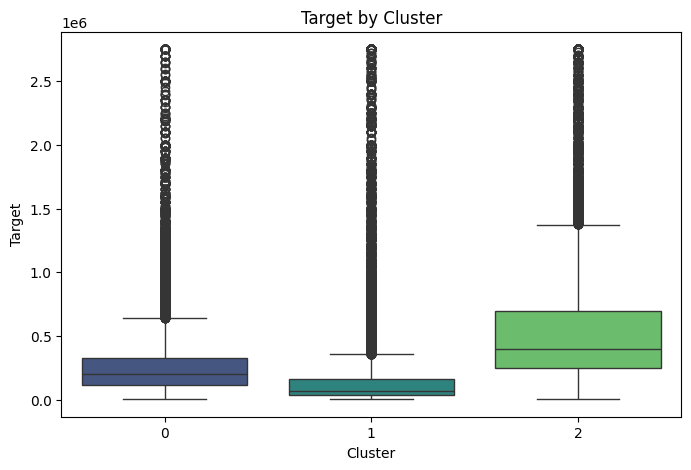

In [12]:
# Cluster vs Target
df_cluster = pd.DataFrame({"Cluster": cluster_labels, "Target": y_train.ravel()})
plt.figure(figsize=(8, 5))
sns.boxplot(x="Cluster", y="Target", data=df_cluster, palette="viridis")
plt.title("Target by Cluster")
plt.show()